In [340]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import inv
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import r2_score
from sklearn.svm import LinearSVC, SVC

# Data Preprocessing

In [341]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

## Explore Raw Data

In [342]:
features_df  = pd.read_csv("Data/features.csv")
train_df = pd.read_csv("Data/train.csv")
stores_df = pd.read_csv("Data/stores.csv")
test_df = pd.read_csv("Data/test.csv")

### Explore Features DF

This file contains additional data related to the store, department, and regional activity for the given dates.

In [343]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [344]:
features_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


### Explore Train/Test DF

This is the historical training data, which covers to 2010-02-05 to 2012-11-01.
`test_df` file is identical to train.csv, except we have withheld the weekly sales.

In [345]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [346]:
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [347]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


In [348]:
test_df.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


Since the test dataset is missing the actual weekly sales for those dates (the y label) becuase this was originally used for a Kaggle competition, let's derive both the dev and test datasets from the train_df for the purposes of our project for now (we may decide to use this test dataset and submit to the Kaggle compeititon later on.

### Explore Stores_DF

This file contains anonymized information about the 45 stores, indicating the type and size of store.

In [349]:
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [350]:
stores_df.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


## Merge the Features/Train Datasets together for one DS

In [351]:
features_df = features_df.merge(stores_df, how='inner', on='Store')
df = pd.merge(left=features_df,right=train_df,on=["Store","Date"],how='left')

In [352]:
df.drop("IsHoliday_x",inplace=True,axis=1)
df.rename(columns={"IsHoliday_y":"IsHoliday"},inplace=True)

In [353]:
df.rename(columns={"Type":"Store_Type"},inplace=True)
df.rename(columns={"Size":"Store_Size"},inplace=True)

In [354]:
df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Store_Type,Store_Size,Dept,Weekly_Sales,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,1.0,24924.50,False
1,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2.0,50605.27,False
2,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,3.0,13740.12,False
3,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,4.0,39954.04,False
4,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,5.0,32229.38,False


## Missing Value Treatment and Clean Up

In [355]:
# Check is there any missing values across each column
df.isna().sum()

Store                0
Date                 0
Temperature          0
Fuel_Price           0
MarkDown1       270892
MarkDown2       310793
MarkDown3       284667
MarkDown4       286859
MarkDown5       270138
CPI                585
Unemployment       585
Store_Type           0
Store_Size           0
Dept              1755
Weekly_Sales      1755
IsHoliday         1755
dtype: int64

In [356]:
stores_df.isna().sum()

Store    0
Type     0
Size     0
dtype: int64

In [357]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (features_df.isnull().sum()/features_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total missing values', 'Percentage'])
missing_data

,Total missing values,Percentage
MarkDown2,310793.0,0.643346
MarkDown4,286859.0,0.577045
MarkDown3,284667.0,0.558852
MarkDown1,270892.0,0.507692
MarkDown5,270138.0,0.505495
Dept,1755.0,NaN
Weekly_Sales,1755.0,NaN
IsHoliday,1755.0,0.000000
CPI,585.0,0.071429
Unemployment,585.0,0.071429


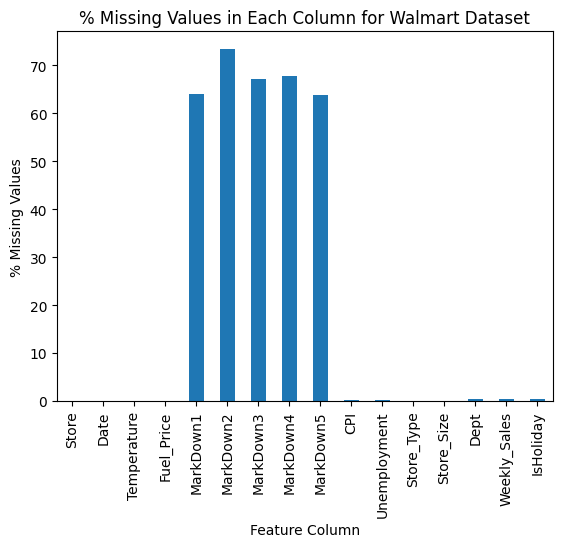

In [358]:
# sns.barplot(features.isnull())
# plt.show()

df_nulls = (df.isna().sum()/len(df)) *100
df_nulls.plot(kind = "bar",
               xlabel = "Feature Column",
               title = "% Missing Values in Each Column for Walmart Dataset",
               ylabel = "% Missing Values")
plt.show()

Some of the info needed for the target y label and relevant department is missing, let's see how many rows are missing and drop them if it's possible

In [359]:
df[df['Dept'].isnull()]

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Store_Type,Store_Size,Dept,Weekly_Sales,IsHoliday
10244,1,2012-11-02,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315,NaN,NaN,NaN
10245,1,2012-11-09,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,A,151315,NaN,NaN,NaN
10246,1,2012-11-16,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,A,151315,NaN,NaN,NaN
10247,1,2012-11-23,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,A,151315,NaN,NaN,NaN
10248,1,2012-11-30,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573,A,151315,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423320,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,B,118221,NaN,NaN,NaN
423321,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,B,118221,NaN,NaN,NaN
423322,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,B,118221,NaN,NaN,NaN
423323,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,B,118221,NaN,NaN,NaN


Only a very small subset of the dataset contains NaNs in the Dept column (and it seems that the NaNs in thr Weekly Sales Column are on the , so let's just drop those rows.

In [360]:
df = df[df['Dept'].notna()]

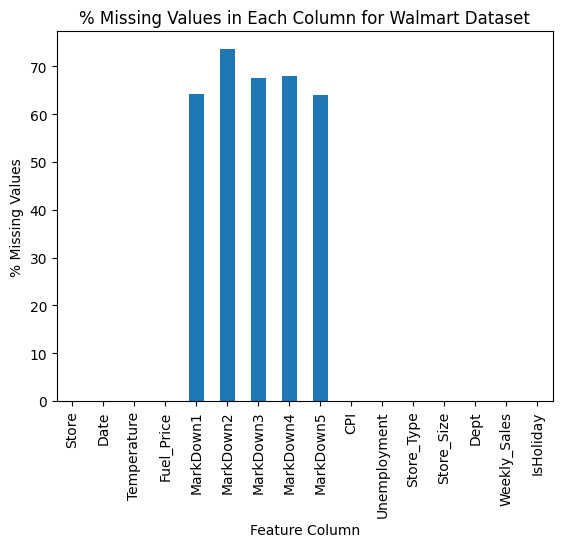

In [361]:

df_nulls = (df.isna().sum()/len(df)) *100
df_nulls.plot(kind = "bar",
               xlabel = "Feature Column",
               title = "% Missing Values in Each Column for Walmart Dataset",
               ylabel = "% Missing Values")
plt.show()

### MarkDown Column Clean-Up

From competition: MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NaN.

In [362]:
df[df['MarkDown1'].notna()]

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Store_Type,Store_Size,Dept,Weekly_Sales,IsHoliday
6587,1,2011-11-11,59.11,3.297,10382.90,6115.67,215.07,2406.62,6551.42,217.998085,7.866,A,151315,1.0,18689.54,False
6588,1,2011-11-11,59.11,3.297,10382.90,6115.67,215.07,2406.62,6551.42,217.998085,7.866,A,151315,2.0,44936.47,False
6589,1,2011-11-11,59.11,3.297,10382.90,6115.67,215.07,2406.62,6551.42,217.998085,7.866,A,151315,3.0,9959.64,False
6590,1,2011-11-11,59.11,3.297,10382.90,6115.67,215.07,2406.62,6551.42,217.998085,7.866,A,151315,4.0,36826.52,False
6591,1,2011-11-11,59.11,3.297,10382.90,6115.67,215.07,2406.62,6551.42,217.998085,7.866,A,151315,5.0,31002.65,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423281,45,2012-10-26,58.85,3.882,4018.91,58.08,100.00,211.94,858.33,192.308899,8.667,B,118221,93.0,2487.80,False
423282,45,2012-10-26,58.85,3.882,4018.91,58.08,100.00,211.94,858.33,192.308899,8.667,B,118221,94.0,5203.31,False
423283,45,2012-10-26,58.85,3.882,4018.91,58.08,100.00,211.94,858.33,192.308899,8.667,B,118221,95.0,56017.47,False
423284,45,2012-10-26,58.85,3.882,4018.91,58.08,100.00,211.94,858.33,192.308899,8.667,B,118221,97.0,6817.48,False


A lot of data from 1 year is missing markdowns, and there are NaNs, so for these NaNs we may want to consider a mean simple imputer based on the department and store type.

In [363]:
df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Store_Type,Store_Size,Dept,Weekly_Sales,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,1.0,24924.50,False
1,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,2.0,50605.27,False
2,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,3.0,13740.12,False
3,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,4.0,39954.04,False
4,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,5.0,32229.38,False


In [364]:
#reference from: 
# https://stackoverflow.com/questions/73411674/scikit-learn-imputer-in-a-pandas-dataframe-group-by-id

# Replace MarkDown NaN with mean amount of same dept and store type
df['MarkDown1'] = df.groupby(["Dept", "Store_Type"]).MarkDown1.transform(lambda x: x.fillna(x.mean()))
df['MarkDown2'] = df.groupby(["Dept", "Store_Type"]).MarkDown2.transform(lambda x: x.fillna(x.mean()))
df['MarkDown3'] = df.groupby(["Dept", "Store_Type"]).MarkDown3.transform(lambda x: x.fillna(x.mean()))
df['MarkDown4'] = df.groupby(["Dept", "Store_Type"]).MarkDown4.transform(lambda x: x.fillna(x.mean()))
df['MarkDown5'] = df.groupby(["Dept", "Store_Type"]).MarkDown5.transform(lambda x: x.fillna(x.mean()))


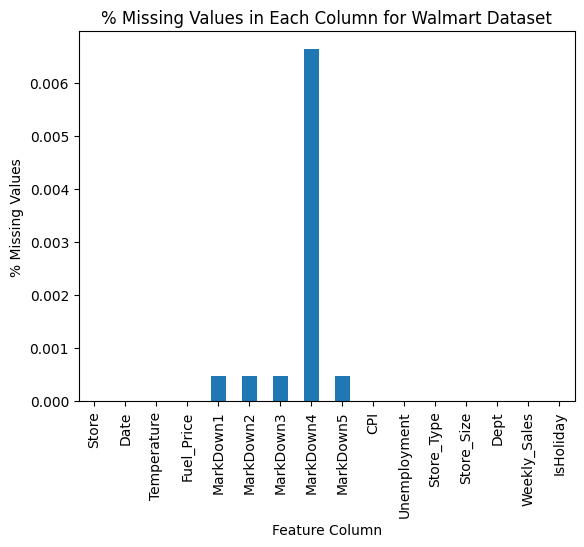

In [365]:
df_nulls = (df.isna().sum()/len(df)) *100
df_nulls.plot(kind = "bar",
               xlabel = "Feature Column",
               title = "% Missing Values in Each Column for Walmart Dataset",
               ylabel = "% Missing Values")
plt.show()

It appears that there is a very small % of missing values in the MarkDown columns even after imputation. This is likely because there is no existing data available for the store type and dept that can be used to impute these nulls. For these very small number cases, we will just use the simple imputation of MarkDown by Dept (although the Store Type may impact the MarkDown amount in these columns, since the # of columns that this impacts is very small, we expect the impact to also be very small.

In [366]:
# Replace MarkDown NaN with mean amount of same dept and store type
df['MarkDown1'] = df.groupby(["Dept"]).MarkDown1.transform(lambda x: x.fillna(x.mean()))
df['MarkDown2'] = df.groupby(["Dept"]).MarkDown2.transform(lambda x: x.fillna(x.mean()))
df['MarkDown3'] = df.groupby(["Dept"]).MarkDown3.transform(lambda x: x.fillna(x.mean()))
df['MarkDown4'] = df.groupby(["Dept"]).MarkDown4.transform(lambda x: x.fillna(x.mean()))
df['MarkDown5'] = df.groupby(["Dept"]).MarkDown5.transform(lambda x: x.fillna(x.mean()))

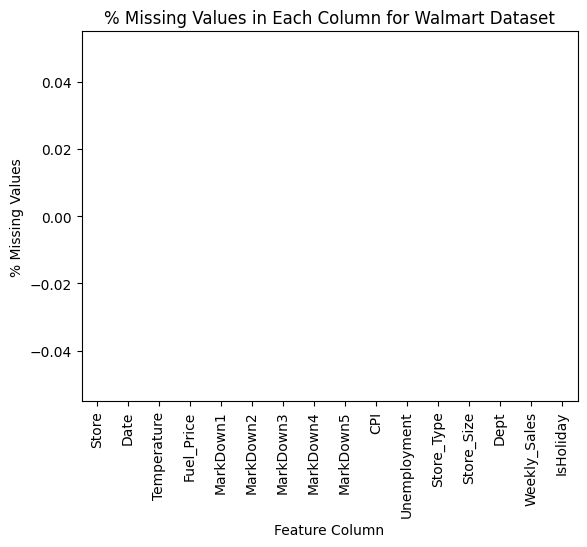

In [367]:
df_nulls = (df.isna().sum()/len(df)) *100
df_nulls.plot(kind = "bar",
               xlabel = "Feature Column",
               title = "% Missing Values in Each Column for Walmart Dataset",
               ylabel = "% Missing Values")
plt.show()

In [368]:
df.isnull().sum()

Store           0
Date            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Store_Type      0
Store_Size      0
Dept            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

No more missing values!

In [369]:
# save a copy for some feature importance later
no_na_df = df.copy()

### Categorical Variables/Data Clean-Up

Before handling the other missing values (i.e. MarkDown columns, let's do some clean-up.

In [370]:
df['Date'] = pd.to_datetime(df['Date'])

In [371]:
from sklearn.impute import SimpleImputer

df["IsHoliday"] = pd.get_dummies(df["IsHoliday"], 
                drop_first = True, 
                dtype = int )


In [372]:
df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Store_Type,Store_Size,Dept,Weekly_Sales,IsHoliday
0,1,2010-02-05,42.31,2.572,8405.311261,3683.098916,1592.279961,3867.368141,5863.472602,211.096358,8.106,A,151315,1.0,24924.50,0
1,1,2010-02-05,42.31,2.572,8405.311261,3683.098916,1592.279961,3867.368141,5863.472602,211.096358,8.106,A,151315,2.0,50605.27,0
2,1,2010-02-05,42.31,2.572,8405.311261,3683.098916,1592.279961,3867.368141,5863.472602,211.096358,8.106,A,151315,3.0,13740.12,0
3,1,2010-02-05,42.31,2.572,8405.311261,3683.098916,1592.279961,3867.368141,5863.472602,211.096358,8.106,A,151315,4.0,39954.04,0
4,1,2010-02-05,42.31,2.572,8405.311261,3683.098916,1592.279961,3867.368141,5863.472602,211.096358,8.106,A,151315,5.0,32229.38,0


In [373]:
df["Store_Type"].nunique()

3

We do not know if store type has any ordinal importance, so we will just use a simple imputer for this/

In [374]:
type_dummies = pd.get_dummies(df["Store_Type"], 
                drop_first = True, 
                dtype = int )

df = df.drop(["Store_Type"], axis = 1)

df = pd.concat([df, type_dummies], axis=1)
df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Store_Size,Dept,Weekly_Sales,IsHoliday,B,C
0,1,2010-02-05,42.31,2.572,8405.311261,3683.098916,1592.279961,3867.368141,5863.472602,211.096358,8.106,151315,1.0,24924.50,0,0,0
1,1,2010-02-05,42.31,2.572,8405.311261,3683.098916,1592.279961,3867.368141,5863.472602,211.096358,8.106,151315,2.0,50605.27,0,0,0
2,1,2010-02-05,42.31,2.572,8405.311261,3683.098916,1592.279961,3867.368141,5863.472602,211.096358,8.106,151315,3.0,13740.12,0,0,0
3,1,2010-02-05,42.31,2.572,8405.311261,3683.098916,1592.279961,3867.368141,5863.472602,211.096358,8.106,151315,4.0,39954.04,0,0,0
4,1,2010-02-05,42.31,2.572,8405.311261,3683.098916,1592.279961,3867.368141,5863.472602,211.096358,8.106,151315,5.0,32229.38,0,0,0


In [375]:
df.rename(columns={"B":"Store_Type_B"},inplace=True)
df.rename(columns={"C":"Store_Type_C"},inplace=True)
df.tail()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Store_Size,Dept,Weekly_Sales,IsHoliday,Store_Type_B,Store_Type_C
423281,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,118221,93.0,2487.80,0,1,0
423282,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,118221,94.0,5203.31,0,1,0
423283,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,118221,95.0,56017.47,0,1,0
423284,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,118221,97.0,6817.48,0,1,0
423285,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,118221,98.0,1076.80,0,1,0


In [376]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 421570 entries, 0 to 423285
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Date          421570 non-null  datetime64[ns]
 2   Temperature   421570 non-null  float64       
 3   Fuel_Price    421570 non-null  float64       
 4   MarkDown1     421570 non-null  float64       
 5   MarkDown2     421570 non-null  float64       
 6   MarkDown3     421570 non-null  float64       
 7   MarkDown4     421570 non-null  float64       
 8   MarkDown5     421570 non-null  float64       
 9   CPI           421570 non-null  float64       
 10  Unemployment  421570 non-null  float64       
 11  Store_Size    421570 non-null  int64         
 12  Dept          421570 non-null  float64       
 13  Weekly_Sales  421570 non-null  float64       
 14  IsHoliday     421570 non-null  int64         
 15  Store_Type_B  421570 n

### Splitting the Data

In [377]:
# split data into features and labels

df_X = df.drop(columns=['Weekly_Sales'])
df_y = df['Weekly_Sales']

## Exploratory Data Analysis

### Macro Analyses

Before looking into each department's trends for patterns, let's look at the overall dataset patterns

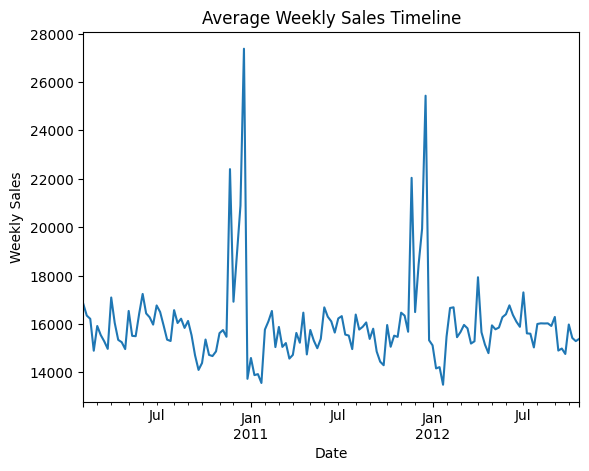

In [378]:
sales_df = df.groupby("Date")["Weekly_Sales"].mean().transpose().plot(
                                                                                                                  kind = "line",
                                                                     title = "Average Weekly Sales Timeline",
                                                                     ylabel = "Weekly Sales",
                                                                 xlabel = "Date")

Let's zoom in to 1 year of sales, like Jan 2011 - Jan 2012.

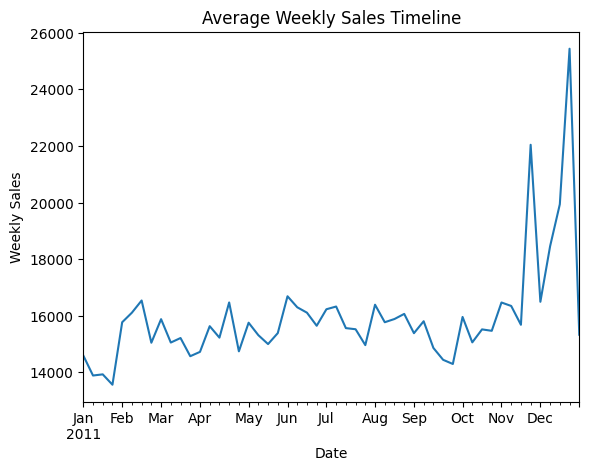

In [379]:
sales_df = df[(df["Date"] > "2011-01-01") & (df["Date"] <= "2012-01-01")].groupby("Date")["Weekly_Sales"].mean().transpose().plot(
                                                                                                                  kind = "line",
                                                                     title = "Average Weekly Sales Timeline",
                                                                     ylabel = "Weekly Sales",
                                                                 xlabel = "Date")

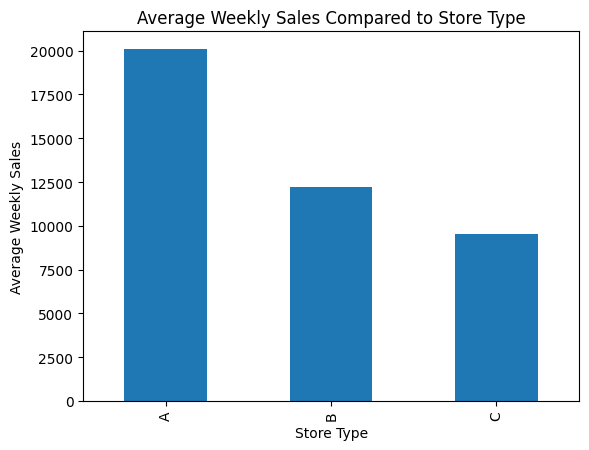

In [380]:

sales_df = no_na_df.groupby("Store_Type")["Weekly_Sales"].mean().plot(kind = "bar",
                                                                     title = "Average Weekly Sales Compared to Store Type",
                                                                     ylabel = "Average Weekly Sales",
                                                                 xlabel = "Store Type")

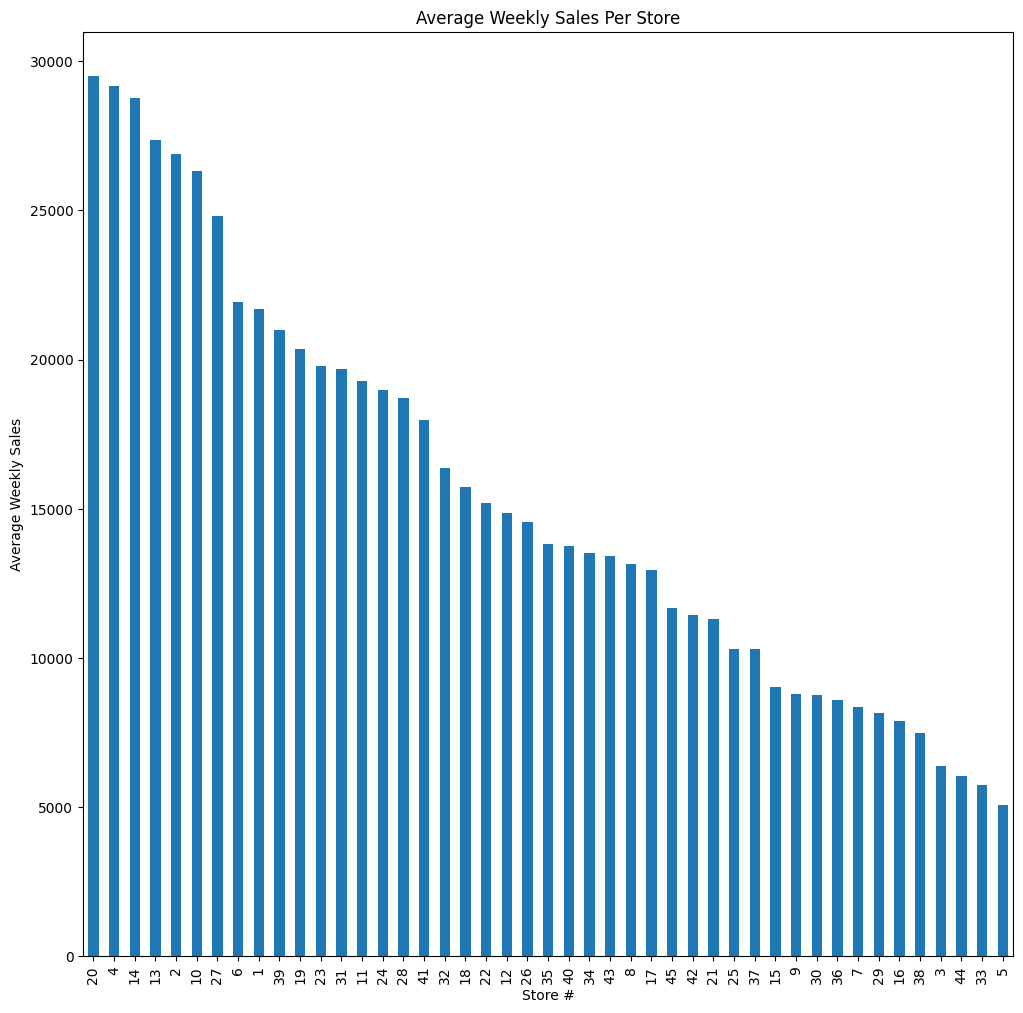

In [381]:
plt.figure(figsize=(12,12))
sales_df = df.groupby("Store")["Weekly_Sales"].mean().sort_values(ascending=False).transpose().plot(kind = "bar",
                                                                     title = "Average Weekly Sales Per Store",
                                                                     ylabel = "Average Weekly Sales",
                                                                 xlabel = "Store #")


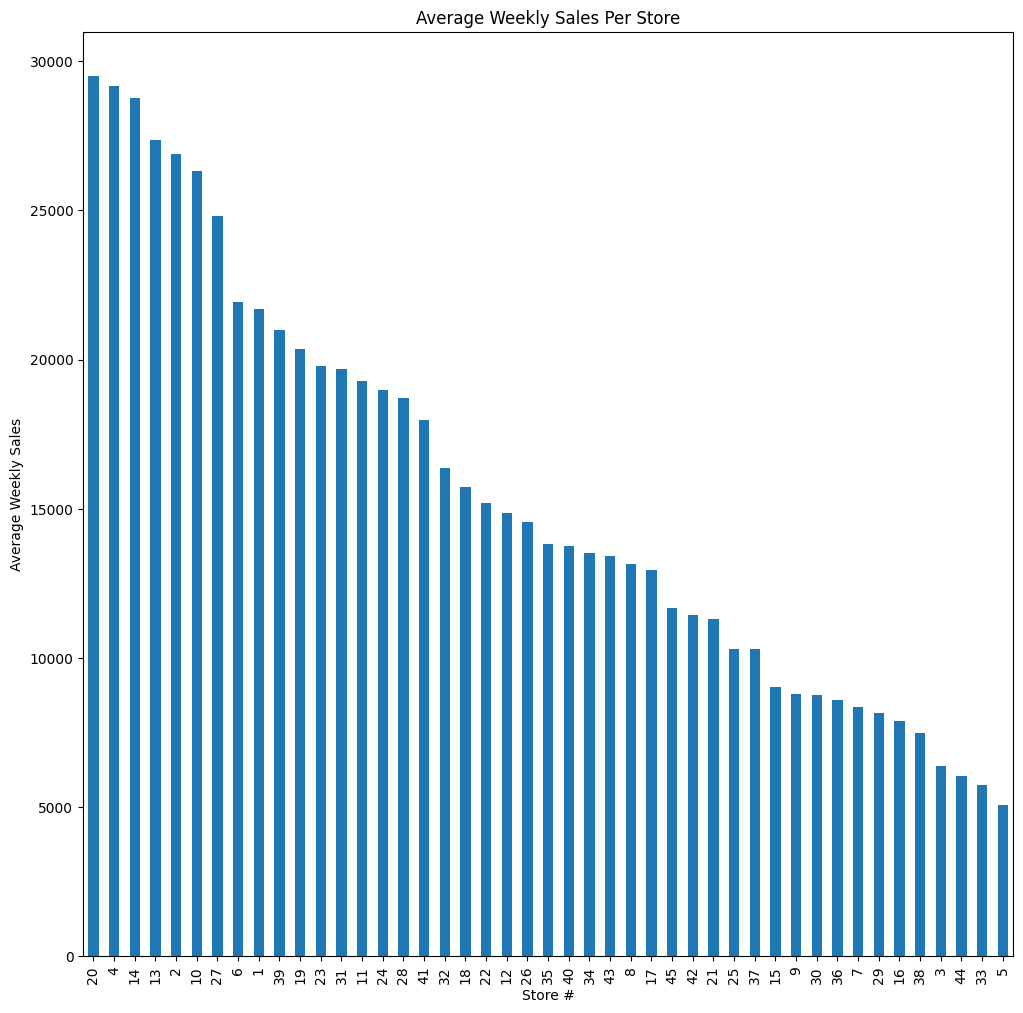

In [382]:
plt.figure(figsize=(12,12))
sales_df = df.groupby("Store")["Weekly_Sales"].mean().sort_values(ascending=False).transpose().plot(kind = "bar",
                                                                     title = "Average Weekly Sales Per Store",
                                                                     ylabel = "Average Weekly Sales",
                                                                 xlabel = "Store #")

In [383]:
no_na_df['Store_Type'].head()

0    A
1    A
2    A
3    A
4    A
Name: Store_Type, dtype: object

In [384]:
no_na_df.groupby("Store")['Store_Type'].max()

Store
1     A
2     A
3     B
4     A
5     B
6     A
7     B
8     A
9     B
10    B
11    A
12    B
13    A
14    A
15    B
16    B
17    B
18    B
19    A
20    A
21    B
22    B
23    B
24    A
25    B
26    A
27    A
28    A
29    B
30    C
31    A
32    A
33    A
34    A
35    B
36    A
37    C
38    C
39    A
40    A
41    A
42    C
43    C
44    C
45    B
Name: Store_Type, dtype: object

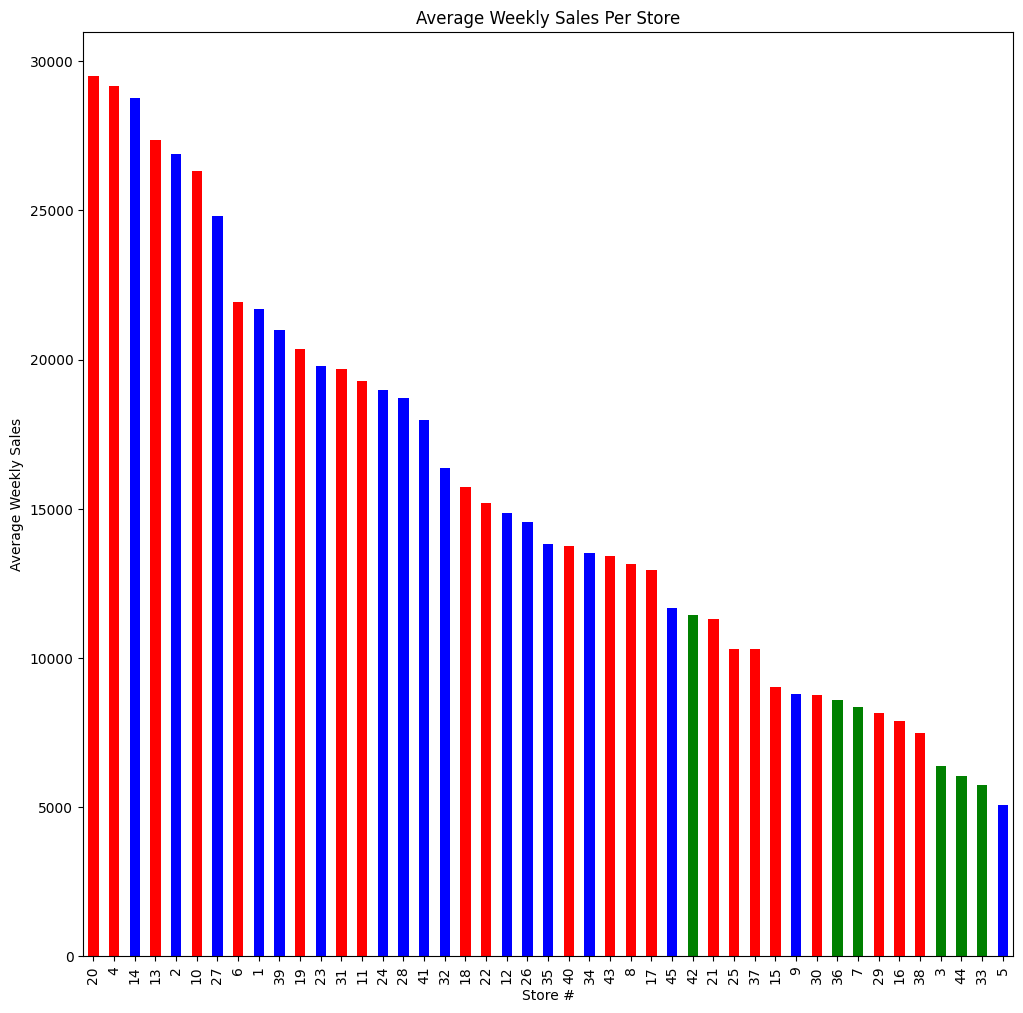

In [385]:
plt.figure(figsize=(12,12))
colors = {'A': 'r', 'B': 'b', 'C': 'g'}
sales_df = no_na_df.groupby("Store")["Weekly_Sales"].mean().sort_values(ascending=False).transpose().plot(kind = "bar",
                                                                    color=[colors[i] for i in no_na_df.groupby("Store")['Store_Type'].max()],
                                                                     title = "Average Weekly Sales Per Store",
                                                                     ylabel = "Average Weekly Sales",
                                                                 xlabel = "Store #")
#sales_df.legend(colors[i] for i in colors)

#sales_df.)


Color legend isn't showing up, but we see that type is not impactful to store sales except store type C sales tend to have lower weekly sales than store types A and B.

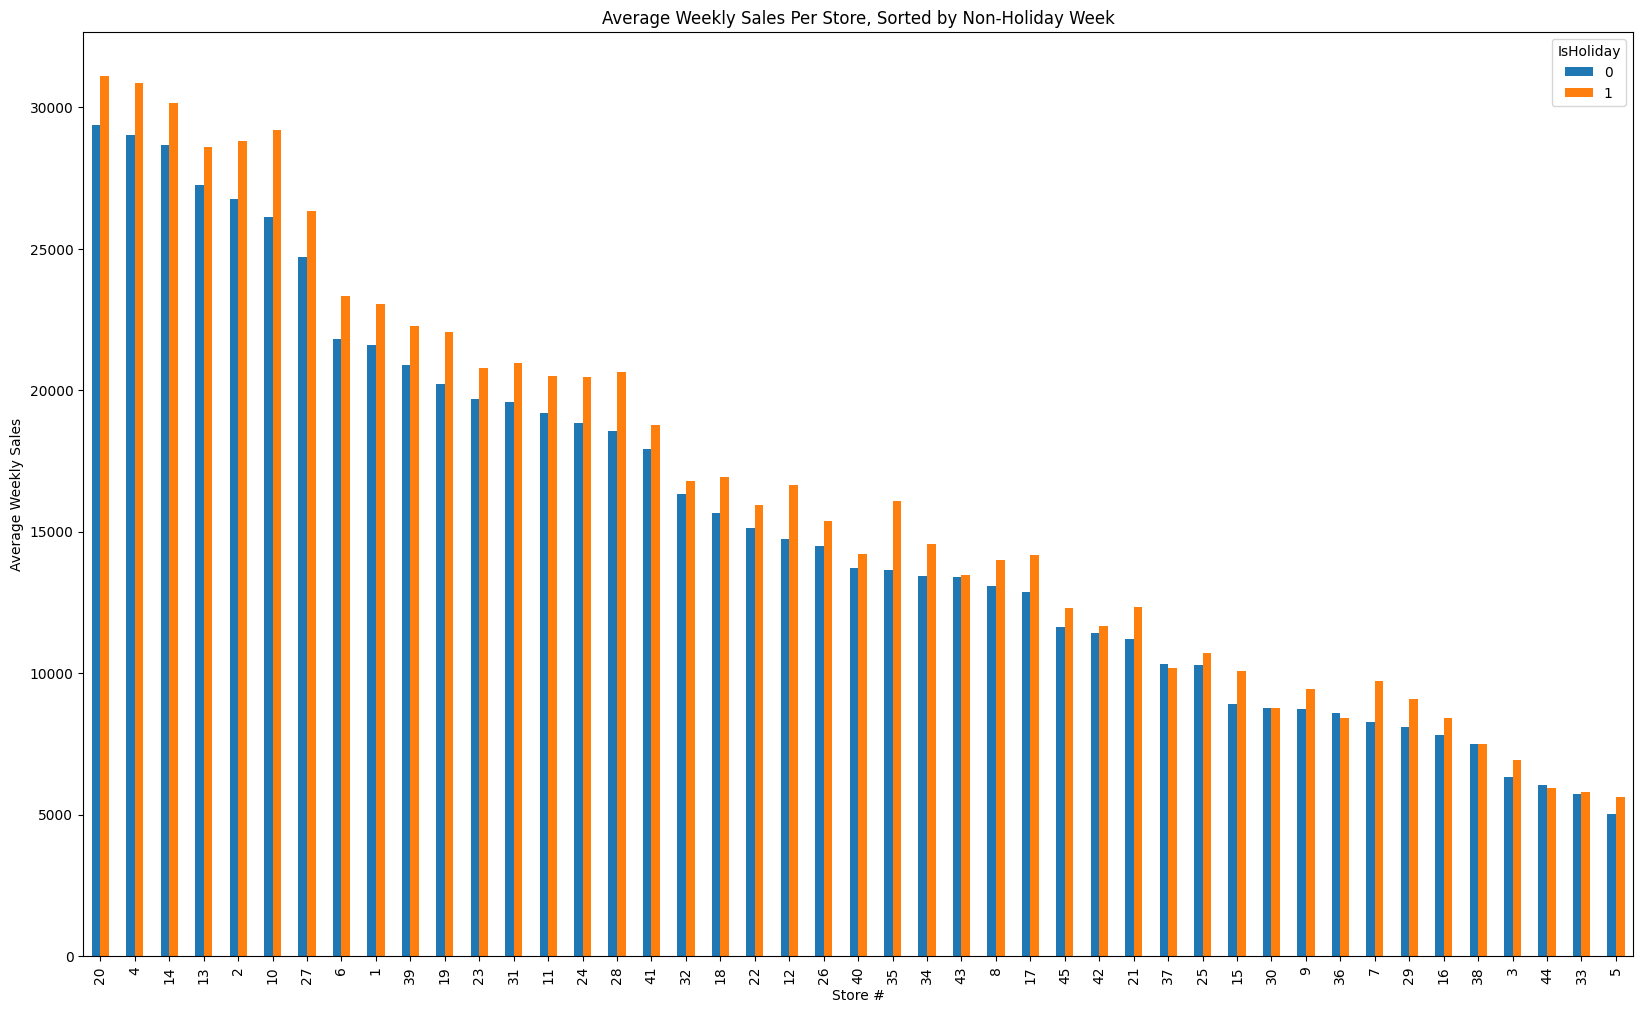

In [386]:


sales_df = df.groupby(["Store", "IsHoliday"])["Weekly_Sales"].mean().unstack().sort_values(by =0,ascending=False).plot(figsize=(20,12),
                                                                                                        kind = "bar",
                                                                     title = "Average Weekly Sales Per Store, Sorted by Non-Holiday Week",
                                                                     ylabel = "Average Weekly Sales",
                                                                 xlabel = "Store #")

This chart is in similar trend to the overall dept weekly sales chart, so we will ignore this.

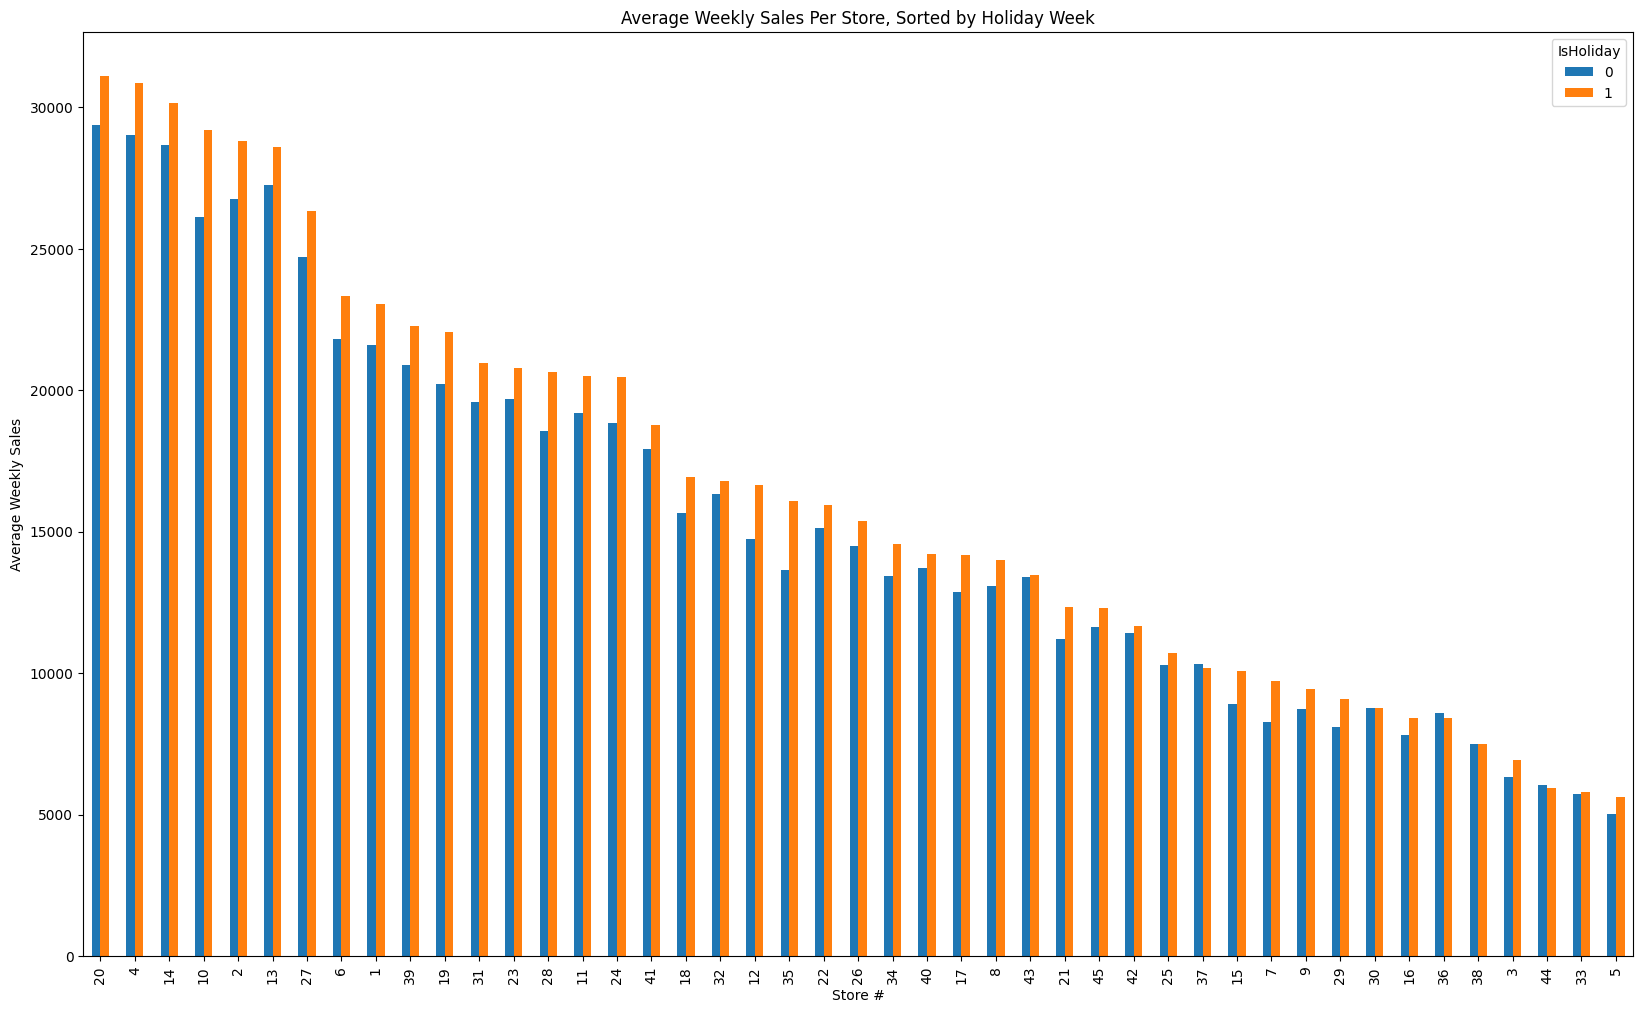

In [387]:


sales_df = df.groupby(["Store", "IsHoliday"])["Weekly_Sales"].mean().unstack().sort_values(by =1,ascending=False).plot(figsize=(20,12),
                                                                                                        kind = "bar",
                                                                     title = "Average Weekly Sales Per Store, Sorted by Holiday Week",
                                                                     ylabel = "Average Weekly Sales",
                                                                 xlabel = "Store #")




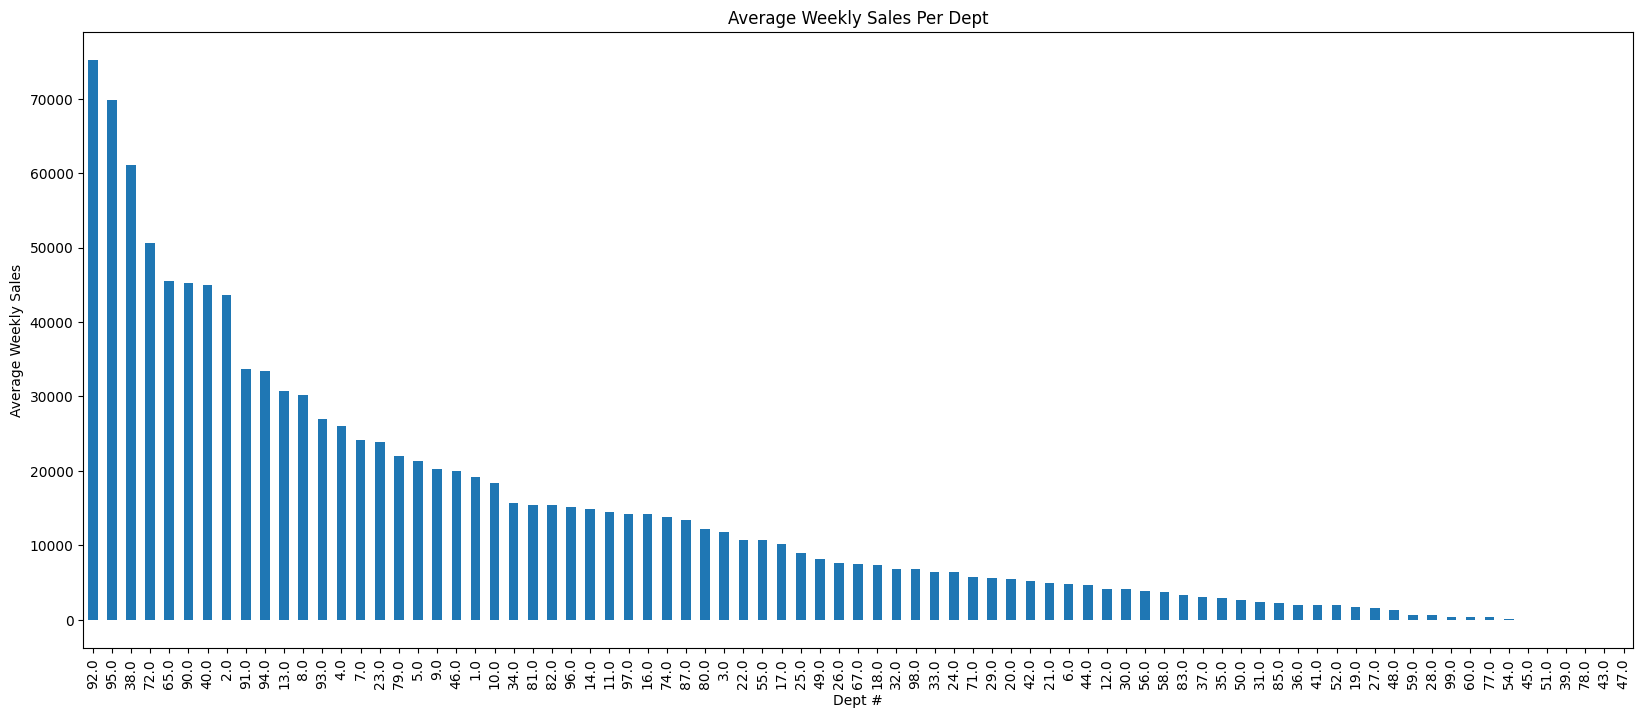

In [388]:
sales_df = df.groupby("Dept")["Weekly_Sales"].mean().sort_values(ascending=False).transpose().plot(kind = "bar",
                                                                     figsize = (20,8),
                                                                            title = "Average Weekly Sales Per Dept",
                                                                     ylabel = "Average Weekly Sales",
                                                                 xlabel = "Dept #")

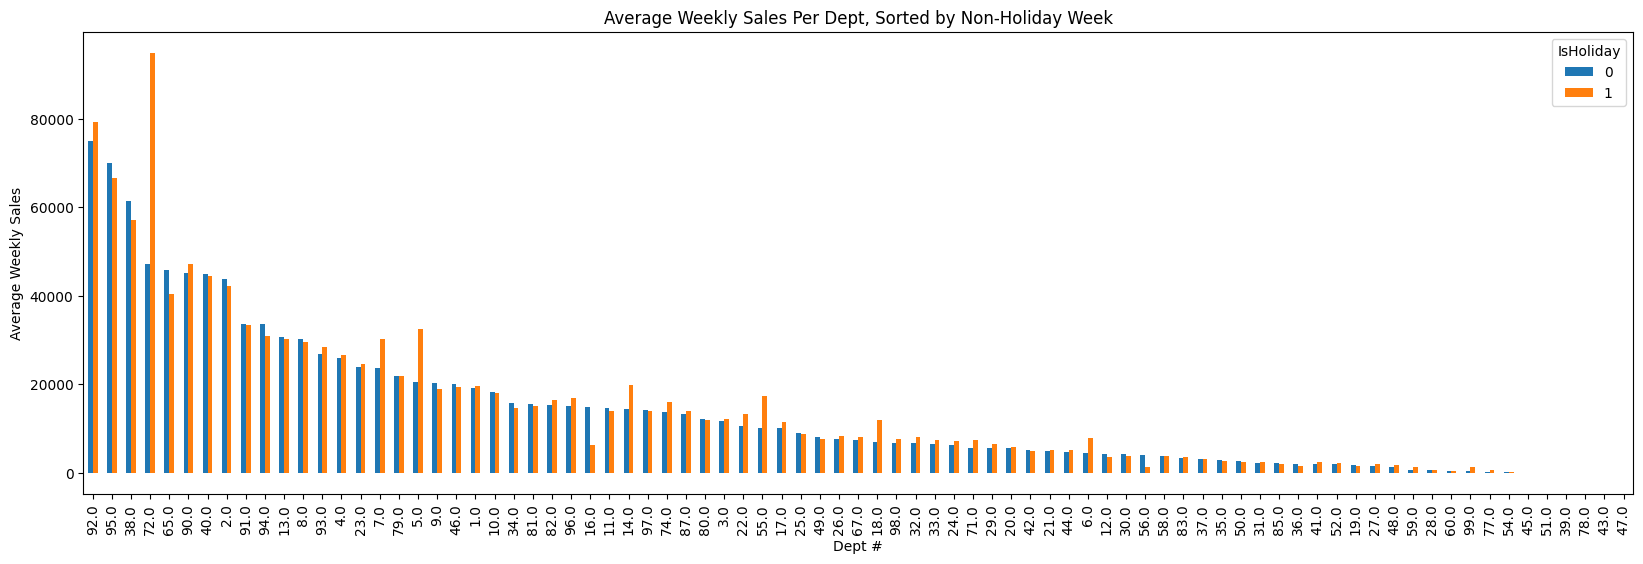

In [389]:
sales_df = df.groupby(["Dept", "IsHoliday"])["Weekly_Sales"].mean().unstack().sort_values(by =0,ascending=False).plot(figsize=(20,6),
                                                                                                        kind = "bar",
                                                                     title = "Average Weekly Sales Per Dept, Sorted by Non-Holiday Week",
                                                                     ylabel = "Average Weekly Sales",
                                                                 xlabel = "Dept #")

This chart is in similar trend to the overall dept weekly sales chart, so we will ignore this.

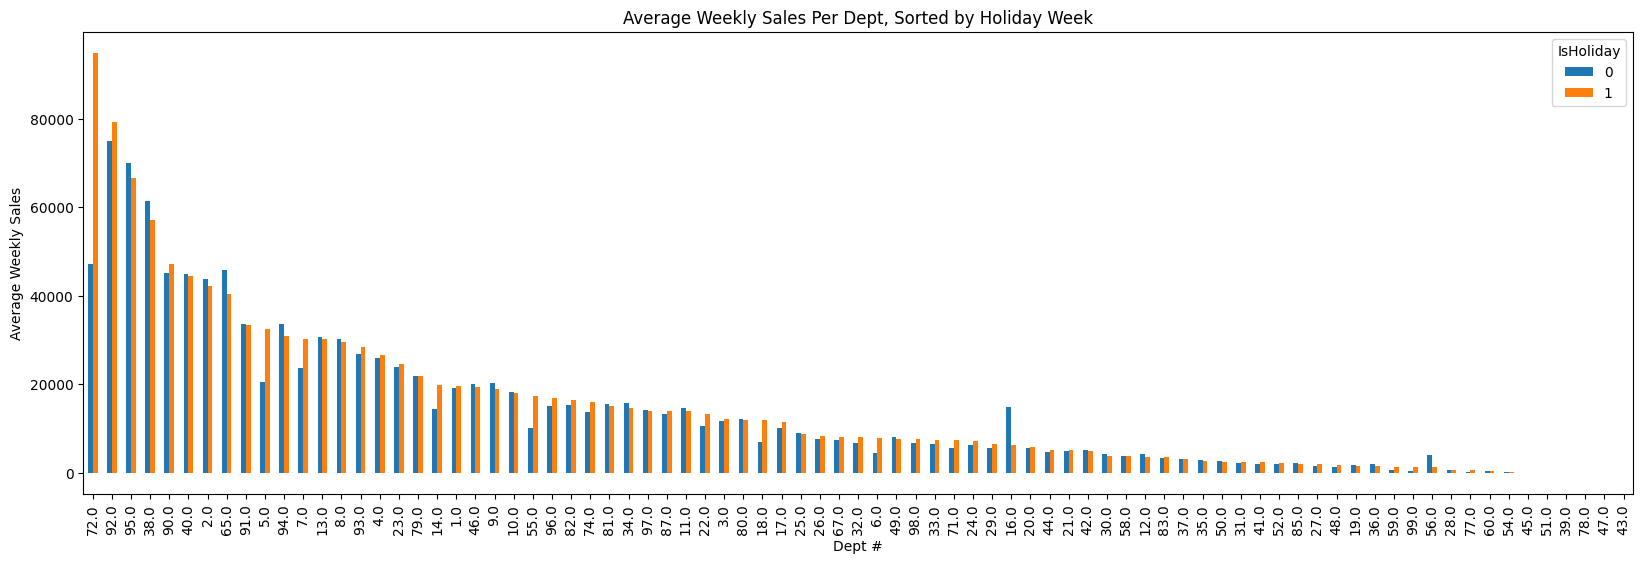

In [390]:
sales_df = df.groupby(["Dept", "IsHoliday"])["Weekly_Sales"].mean().unstack().sort_values(by =1,ascending=False).plot(figsize=(20,6),
                                                                                                        kind = "bar",
                                                                     title = "Average Weekly Sales Per Dept, Sorted by Holiday Week",
                                                                     ylabel = "Average Weekly Sales",
                                                                 xlabel = "Dept #")




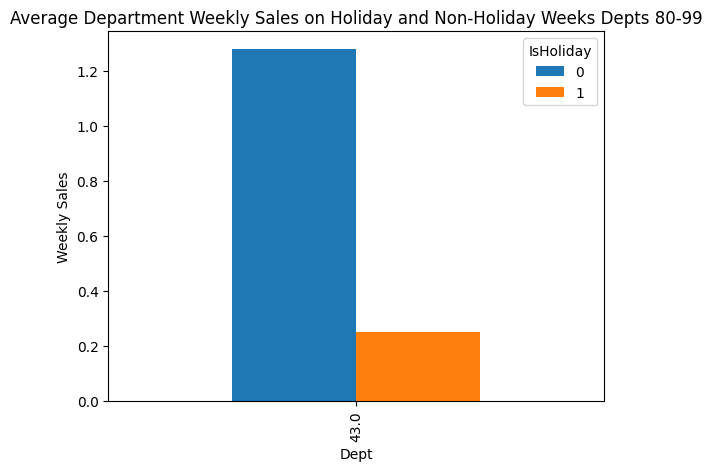

In [391]:
# sanity check to make sure there are sales, even in the worst performing dept
holiday_df6 = df[df["Dept"] == 43.0].groupby(["IsHoliday","Dept"])["Weekly_Sales"].mean().unstack().transpose().plot(
                                                                                                                  kind = "bar",
                                                                     title = "Average Department Weekly Sales on Holiday and Non-Holiday Weeks Depts 80-99",
                                                                     ylabel = "Weekly Sales",
                                                                 xlabel = "Dept")

plt.subplots_adjust(
                    wspace=0.5,
                    hspace=0.5)
plt.show()

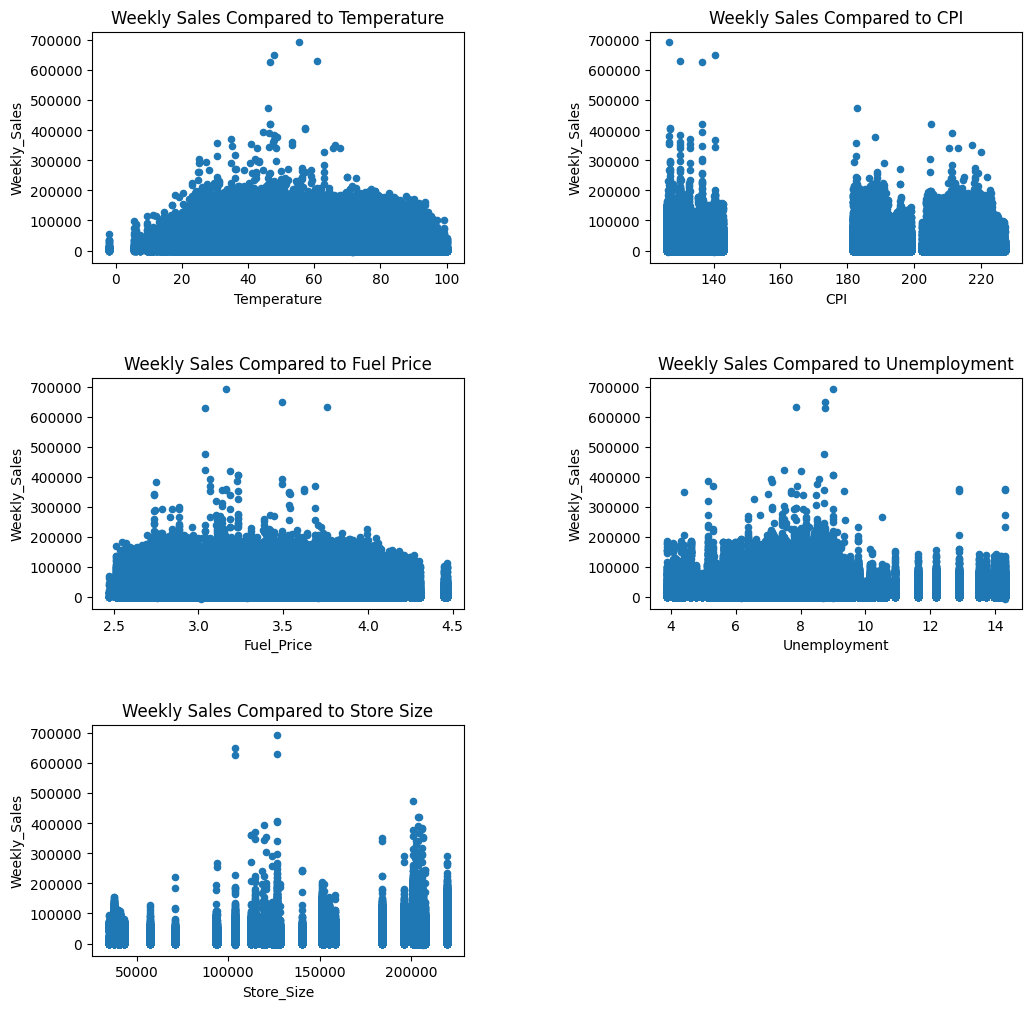

In [392]:
### Code here
fig, axs = plt.subplots(3,2)
# 
fig.set_size_inches(12, 12) # from https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure.set_size_inches

#figure, axis = plt.subplots(2, 2)
temp_df = df.plot(ax = axs[0,0],
                    kind = "scatter",
                    x = "Temperature",
                    y = "Weekly_Sales",
                    title = "Weekly Sales Compared to Temperature")

cpi_df = df.plot(ax = axs[0,1],
                    kind = "scatter",
                    x = "CPI",
                    y = "Weekly_Sales",
                    title = "Weekly Sales Compared to CPI")

fuel_df = df.plot(ax = axs[1,0],
                    kind = "scatter",
                    x = "Fuel_Price",
                    y = "Weekly_Sales",
                    title = "Weekly Sales Compared to Fuel Price")

unemp_df = df.plot(ax = axs[1,1],
                    kind = "scatter",
                    x = "Unemployment",
                    y = "Weekly_Sales",
                    title = "Weekly Sales Compared to Unemployment")

store_size_df = df.plot(ax = axs[2,0],
                    kind = "scatter",
                    x = "Store_Size",
                    y = "Weekly_Sales",
                    title = "Weekly Sales Compared to Store Size")
fig.delaxes(axs[2][1])
plt.subplots_adjust(
                    wspace=0.5,
                    hspace=0.5)
plt.show()

We see some features such as temperature, CPI, and unemployment do not really have an impact on weekly sales, so we should consider dropping those variables.

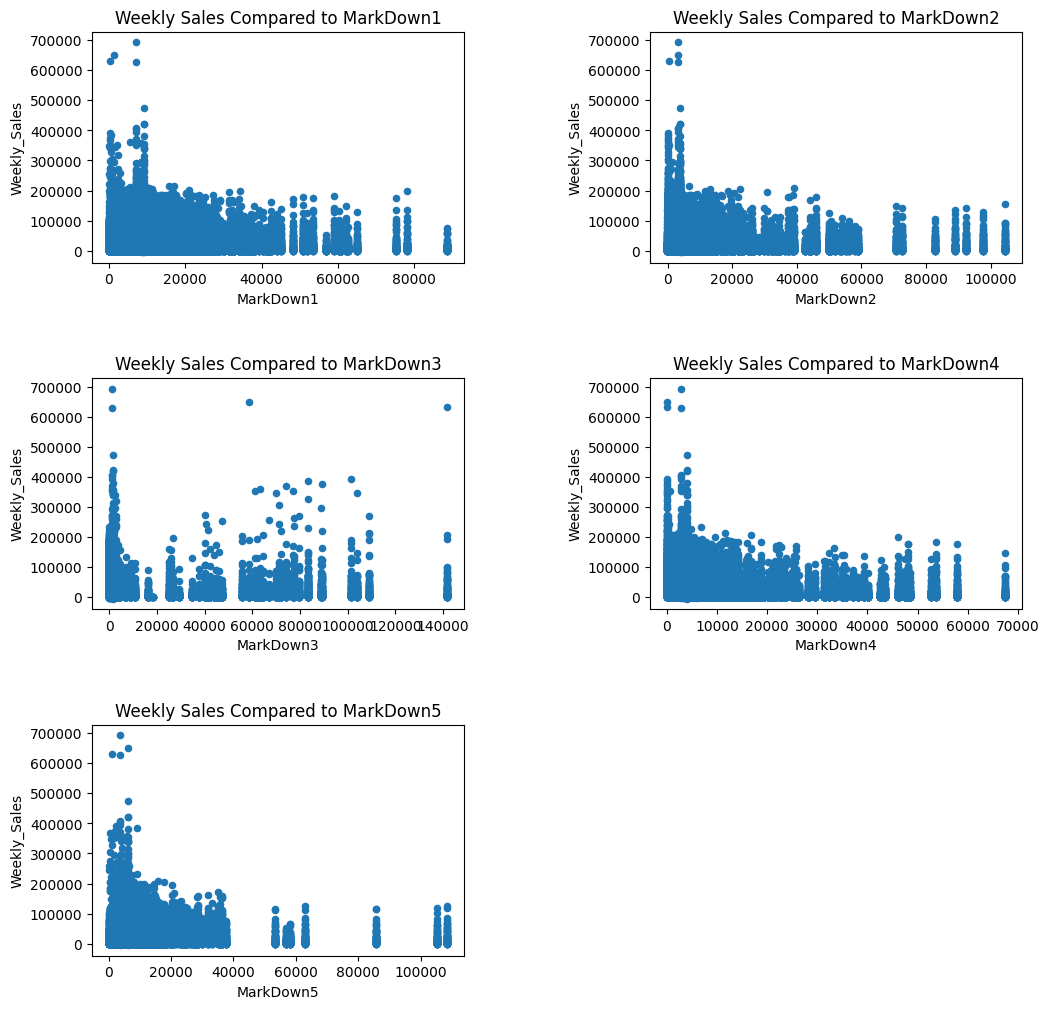

In [393]:
### Code here
fig, axs = plt.subplots(3,2)
# 
fig.set_size_inches(12, 12) # from https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure.set_size_inches

#figure, axis = plt.subplots(2, 2)
md1_df = df.plot(ax = axs[0,0],
                    kind = "scatter",
                    x = "MarkDown1",
                    y = "Weekly_Sales",
                    title = "Weekly Sales Compared to MarkDown1")

md2_df = df.plot(ax = axs[0,1],
                    kind = "scatter",
                    x = "MarkDown2",
                    y = "Weekly_Sales",
                    title = "Weekly Sales Compared to MarkDown2")

md3_df = df.plot(ax = axs[1,0],
                    kind = "scatter",
                    x = "MarkDown3",
                    y = "Weekly_Sales",
                    title = "Weekly Sales Compared to MarkDown3")

md4_df = df.plot(ax = axs[1,1],
                    kind = "scatter",
                    x = "MarkDown4",
                    y = "Weekly_Sales",
                    title = "Weekly Sales Compared to MarkDown4")

md5_df = df.plot(ax = axs[2,0],
                    kind = "scatter",
                    x = "MarkDown5",
                    y = "Weekly_Sales",
                    title = "Weekly Sales Compared to MarkDown5")
fig.delaxes(axs[2][1])
plt.subplots_adjust(
                    wspace=0.5,
                    hspace=0.5)
plt.show()

<Axes: >

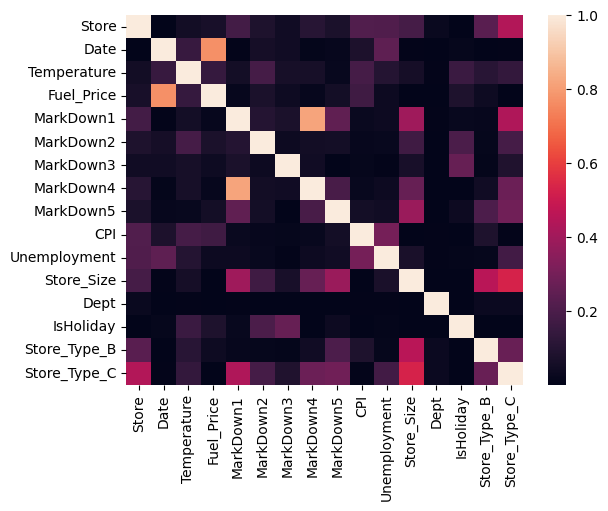

In [394]:
# some help from: https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e
sns.heatmap(df_X.corr().abs())

In [395]:
# some help from: https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e
print(df_X.corr().abs())

                 Store      Date  Temperature  Fuel_Price  MarkDown1  \
Store         1.000000  0.003362     0.050097    0.065290   0.178531   
Date          0.003362  1.000000     0.147064    0.771913   0.005669   
Temperature   0.050097  0.147064     1.000000    0.143859   0.054094   
Fuel_Price    0.065290  0.771913     0.143859    1.000000   0.018271   
MarkDown1     0.178531  0.005669     0.054094    0.018271   1.000000   
MarkDown2     0.081797  0.056601     0.182776    0.070928   0.097012   
MarkDown3     0.043136  0.043691     0.059675    0.035934   0.070733   
MarkDown4     0.105475  0.011796     0.059627    0.016441   0.819566   
MarkDown5     0.073539  0.018462     0.021169    0.053625   0.247959   
CPI           0.211088  0.077001     0.182112    0.164210   0.023818   
Unemployment  0.208552  0.243370     0.096730    0.033853   0.033354   
Store_Size    0.182881  0.005437     0.058313    0.003361   0.397129   
Dept          0.024004  0.004054     0.004437    0.003572   0.00

There are high correlations between Date/Fuel Price and MarkDown 1 & Markdown We will leave date/fuel price
since that correlation shouldn't impact the model, but we may consider dropping MarkDown 1 
or Markdown 4 or adding in some feature importance metrics.

In [396]:
# drop some uncorrelated variables to weekly sales
df_X = df_X.drop(columns=['CPI', "Unemployment", "Temperature"])

<Axes: >

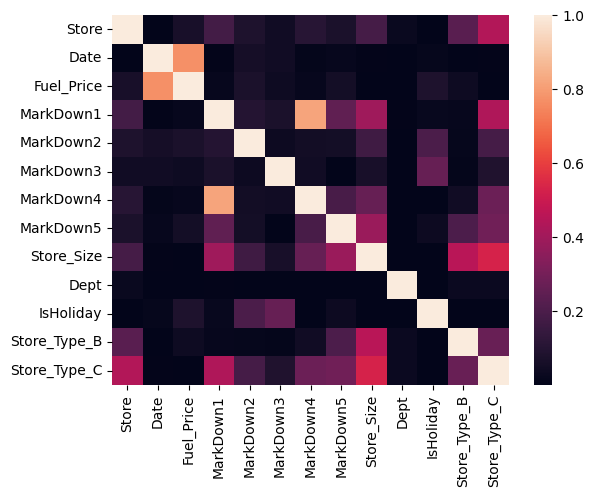

In [397]:
# some help from: https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e
sns.heatmap(df_X.corr().abs())

### Micro Analyses

####  Old Dept Analysis



In [398]:
# did this earlier but it's covered in a previous chart

In [399]:
df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Store_Size,Dept,Weekly_Sales,IsHoliday,Store_Type_B,Store_Type_C
0,1,2010-02-05,42.31,2.572,8405.311261,3683.098916,1592.279961,3867.368141,5863.472602,211.096358,8.106,151315,1.0,24924.50,0,0,0
1,1,2010-02-05,42.31,2.572,8405.311261,3683.098916,1592.279961,3867.368141,5863.472602,211.096358,8.106,151315,2.0,50605.27,0,0,0
2,1,2010-02-05,42.31,2.572,8405.311261,3683.098916,1592.279961,3867.368141,5863.472602,211.096358,8.106,151315,3.0,13740.12,0,0,0
3,1,2010-02-05,42.31,2.572,8405.311261,3683.098916,1592.279961,3867.368141,5863.472602,211.096358,8.106,151315,4.0,39954.04,0,0,0
4,1,2010-02-05,42.31,2.572,8405.311261,3683.098916,1592.279961,3867.368141,5863.472602,211.096358,8.106,151315,5.0,32229.38,0,0,0


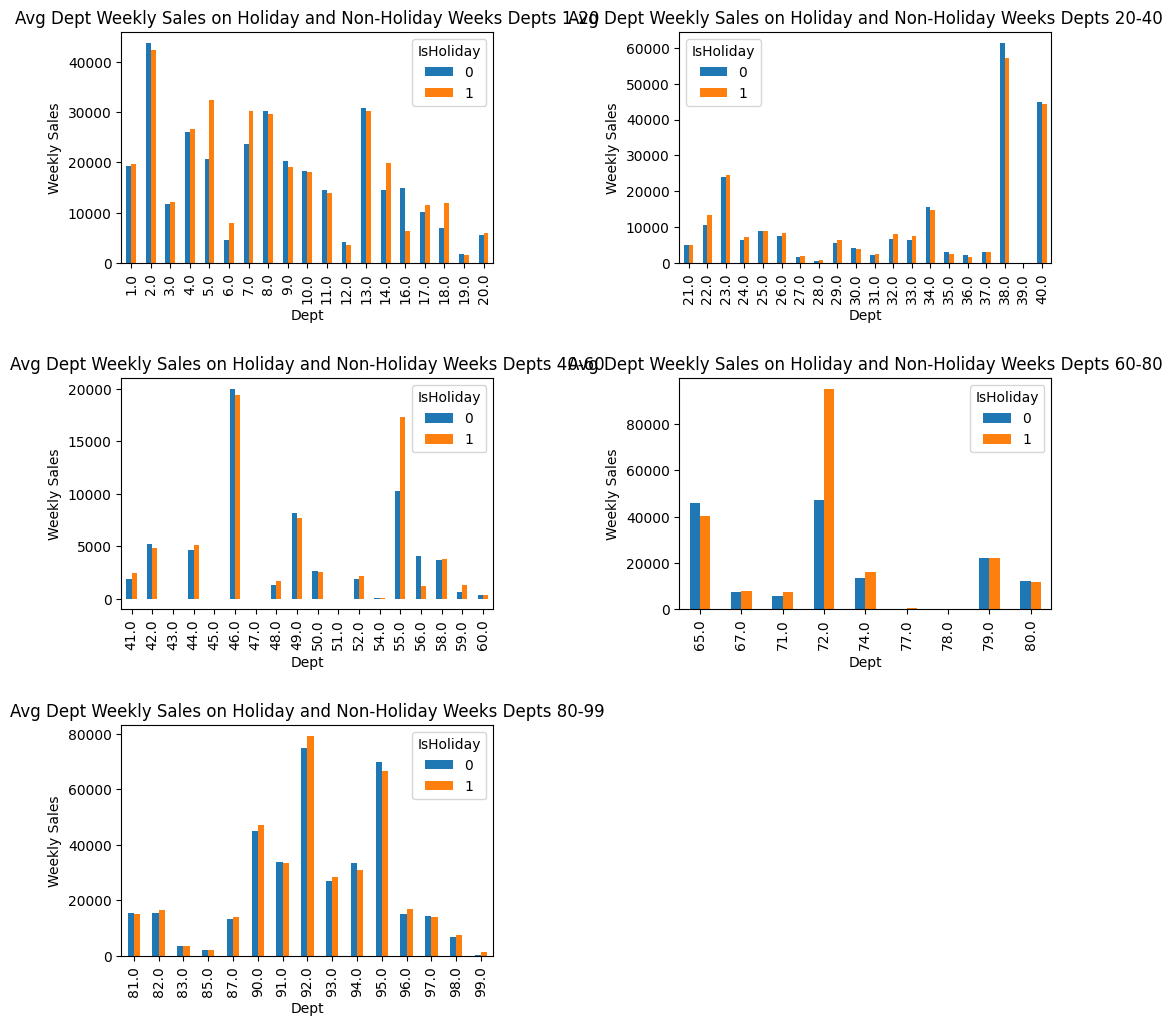

In [400]:
fig, axs = plt.subplots(3,2)

fig.set_size_inches(12, 12) 

holiday_df = df[df["Dept"] <= 20].groupby(["IsHoliday","Dept"])["Weekly_Sales"].mean().unstack().transpose().plot(ax = axs[0,0],
                                                                                                                  kind = "bar",
                                                                     title = "Avg Dept Weekly Sales on Holiday and Non-Holiday Weeks Depts 1-20",
                                                                     ylabel = "Weekly Sales",
                                                                 xlabel = "Dept")
                                                                                       
holiday_df2 = df[(df["Dept"] > 20) & (df["Dept"] <= 40)].groupby(["IsHoliday","Dept"])["Weekly_Sales"].mean().unstack().transpose().plot(ax = axs[0,1],
                                                                                                                  kind = "bar",
                                                                     title = "Avg Dept Weekly Sales on Holiday and Non-Holiday Weeks Depts 20-40",
                                                                     ylabel = "Weekly Sales",
                                                                 xlabel = "Dept")
holiday_df3 = df[(df["Dept"] > 40) & (df["Dept"] <= 60)].groupby(["IsHoliday","Dept"])["Weekly_Sales"].mean().unstack().transpose().plot(ax = axs[1,0],
                                                                                                                  kind = "bar",
                                                                     title = "Avg Dept Weekly Sales on Holiday and Non-Holiday Weeks Depts 40-60",
                                                                     ylabel = "Weekly Sales",
                                                                 xlabel = "Dept")

holiday_df4 = df[(df["Dept"] > 60) & (df["Dept"] <= 80)].groupby(["IsHoliday","Dept"])["Weekly_Sales"].mean().unstack().transpose().plot(ax = axs[1,1],
                                                                                                                  kind = "bar",
                                                                     title = "Avg Dept Weekly Sales on Holiday and Non-Holiday Weeks Depts 60-80",
                                                                     ylabel = "Weekly Sales",
                                                                 xlabel = "Dept")

holiday_df5 = df[df["Dept"] > 80].groupby(["IsHoliday","Dept"])["Weekly_Sales"].mean().unstack().transpose().plot(ax = axs[2,0],
                                                                                                                  kind = "bar",
                                                                     title = "Avg Dept Weekly Sales on Holiday and Non-Holiday Weeks Depts 80-99",
                                                                     ylabel = "Weekly Sales",
                                                                 xlabel = "Dept")

fig.delaxes(axs[2][1])
plt.subplots_adjust(
                    wspace=0.5,
                    hspace=0.5)
plt.show()

## Train Test Split

Now let's explore some features in our test data.

In [401]:
test_df

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False
...,...,...,...,...
115059,45,98,2013-06-28,False
115060,45,98,2013-07-05,False
115061,45,98,2013-07-12,False
115062,45,98,2013-07-19,False


Now let's do a time-series friendly split before feeding our data into our initial set of models. Note that we are not using the `test.csv` provided since it does not come with the true `Weekly_Sales` values, so we are deriving our test dataset from the provided train dataset for the focus of this project

In [402]:
#shuffle will be false because we want this to be time series
df_X_dev, df_X_test, df_y_dev, df_y_test = train_test_split(df_X, df_y, shuffle = False, test_size=0.2, random_state = 42)

df_X_train, df_X_val, df_y_train, df_y_val = train_test_split(df_X_dev, df_y_dev, shuffle = False, test_size=0.25, random_state = 42)


In [403]:
# sanity check there is no data leakage

In [404]:
df_X_dev.head()

,Store,Date,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Store_Size,Dept,IsHoliday,Store_Type_B,Store_Type_C
0,1,2010-02-05,2.572,8405.311261,3683.098916,1592.279961,3867.368141,5863.472602,151315,1.0,0,0,0
1,1,2010-02-05,2.572,8405.311261,3683.098916,1592.279961,3867.368141,5863.472602,151315,2.0,0,0,0
2,1,2010-02-05,2.572,8405.311261,3683.098916,1592.279961,3867.368141,5863.472602,151315,3.0,0,0,0
3,1,2010-02-05,2.572,8405.311261,3683.098916,1592.279961,3867.368141,5863.472602,151315,4.0,0,0,0
4,1,2010-02-05,2.572,8405.311261,3683.098916,1592.279961,3867.368141,5863.472602,151315,5.0,0,0,0


In [405]:
df_X_dev.tail()

,Store,Date,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Store_Size,Dept,IsHoliday,Store_Type_B,Store_Type_C
338577,35,2011-12-16,3.413,5115.93,0.27,10748.31,601.89,14608.23,103681,55.0,0,1,0
338578,35,2011-12-16,3.413,5115.93,0.27,10748.31,601.89,14608.23,103681,56.0,0,1,0
338579,35,2011-12-16,3.413,5115.93,0.27,10748.31,601.89,14608.23,103681,58.0,0,1,0
338580,35,2011-12-16,3.413,5115.93,0.27,10748.31,601.89,14608.23,103681,59.0,0,1,0
338581,35,2011-12-16,3.413,5115.93,0.27,10748.31,601.89,14608.23,103681,60.0,0,1,0


In [406]:
df_X_test.head()

,Store,Date,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Store_Size,Dept,IsHoliday,Store_Type_B,Store_Type_C
338582,35,2011-12-16,3.413,5115.93,0.27,10748.31,601.89,14608.23,103681,67.0,0,1,0
338583,35,2011-12-16,3.413,5115.93,0.27,10748.31,601.89,14608.23,103681,71.0,0,1,0
338584,35,2011-12-16,3.413,5115.93,0.27,10748.31,601.89,14608.23,103681,72.0,0,1,0
338585,35,2011-12-16,3.413,5115.93,0.27,10748.31,601.89,14608.23,103681,74.0,0,1,0
338586,35,2011-12-16,3.413,5115.93,0.27,10748.31,601.89,14608.23,103681,77.0,0,1,0


In [407]:
df_X_test.tail()

,Store,Date,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Store_Size,Dept,IsHoliday,Store_Type_B,Store_Type_C
423281,45,2012-10-26,3.882,4018.91,58.08,100.0,211.94,858.33,118221,93.0,0,1,0
423282,45,2012-10-26,3.882,4018.91,58.08,100.0,211.94,858.33,118221,94.0,0,1,0
423283,45,2012-10-26,3.882,4018.91,58.08,100.0,211.94,858.33,118221,95.0,0,1,0
423284,45,2012-10-26,3.882,4018.91,58.08,100.0,211.94,858.33,118221,97.0,0,1,0
423285,45,2012-10-26,3.882,4018.91,58.08,100.0,211.94,858.33,118221,98.0,0,1,0


### Additional Data Prep

### Initial Model Set-Up Predictions

### ML

##### Manage Features

In [408]:
df_X = df.drop(columns=['Weekly_Sales'])
df_X = df_X.sort_values(by=['Date'])
df_y = df['Weekly_Sales']

df_X['Date'] = pd.to_datetime(df_X['Date'])
df_X['Month'] = df_X['Date'].dt.month
df_X['Day'] = df_X['Date'].dt.day

df_X = df_X.drop(columns=['CPI', "Unemployment", "Temperature", "Date", "Store"])

##### Split data

In [409]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, shuffle = False, test_size=0.25, random_state = 42)

##### Standard Scaler

In [410]:
selected_features = ["Fuel_Price", "MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5", "Store_Size"]
scaler = StandardScaler()

X_train[selected_features] = scaler.fit_transform(X_train[selected_features])
X_test[selected_features] = scaler.transform(X_test[selected_features])

##### Ridge

In [411]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [412]:
param_grid = {
    'alpha': np.logspace(-4, 4, 100)
}

ridge_model = Ridge()

grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['alpha']
best_model = grid_search.best_estimator_

y_test_pred = best_model.predict(X_test)
test_error = mean_squared_error(y_test, y_test_pred)

print(f"Best Alpha for Ridge Regression: {best_alpha:.4f}")
print(f"Test Mean Squared Error: {test_error:.2f}")

Best Alpha for Ridge Regression: 10000.0000
Test Mean Squared Error: 360514314.86


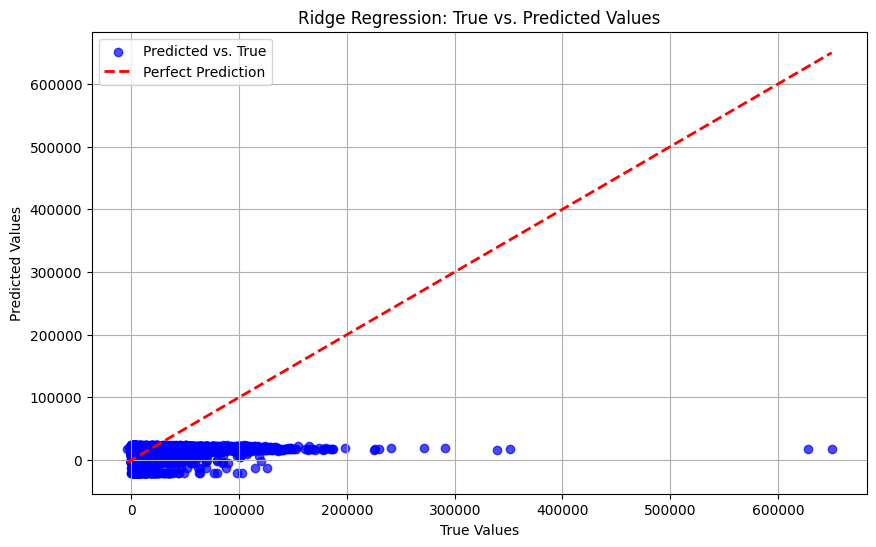

In [413]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue', label='Predicted vs. True', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Ridge Regression: True vs. Predicted Values')
plt.legend()
plt.grid()
plt.show()

##### XGBOOST

In [417]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid to search over
#param_grid = {
#    'n_estimators': [100, 200, 300],
#    'max_depth': [3, 4, 5],
#    'learning_rate': [0.01, 0.1, 0.2],
#    'reg_alpha': np.logspace(-4, 4, 100),
#}

xgb_model = XGBRegressor()

#grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
#grid_search.fit(X_train, y_train)

#best_params = grid_search.best_params_
#best_model = grid_search.best_estimator_ 
best_model = xgb_model.fit(X_train, y_train)

y_test_pred = best_model.predict(X_test)

test_error = mean_squared_error(y_test, y_test_pred)

# Report the results
#print(f"Best Hyperparameters: {best_params}")
print(f"Test Mean Squared Error: {test_error:.2f}")

Test Mean Squared Error: 436228237.25


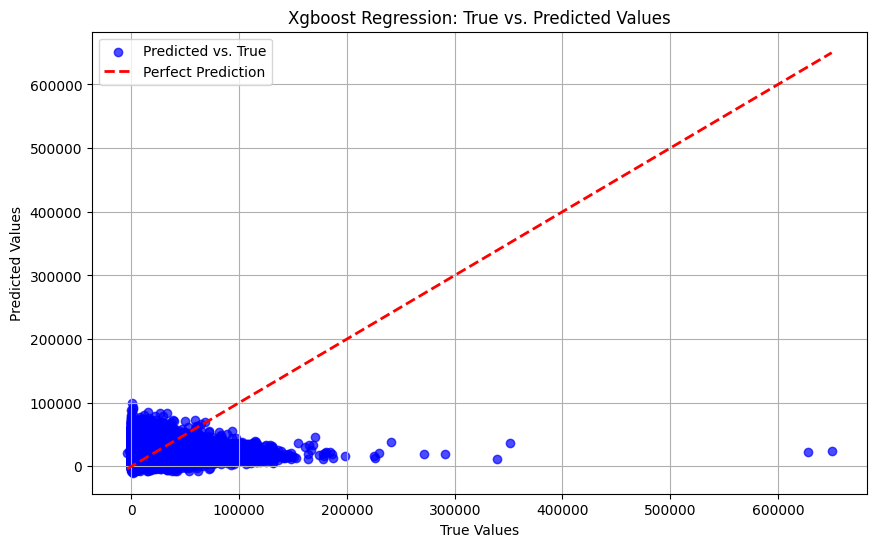

In [418]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue', label='Predicted vs. True', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Xgboost Regression: True vs. Predicted Values')
plt.legend()
plt.grid()
plt.show()

### Random Forest

In [421]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

#param_grid = {
#    'n_estimators': [100, 200, 300],
#    'max_depth': [5, 10, 15],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4]
#}

rf_model = RandomForestRegressor(max_depth=15)

#grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
#grid_search.fit(X_train, y_train)

#best_params = grid_search.best_params_
#best_model = grid_search.best_estimator_
best_model = rf_model.fit(X_train, y_train)

y_test_pred = best_model.predict(X_test)
test_error = mean_squared_error(y_test, y_test_pred)

#print(f"Best Hyperparameters: {best_params}")
print(f"Test Mean Squared Error: {test_error:.2f}")


Test Mean Squared Error: 452439756.08


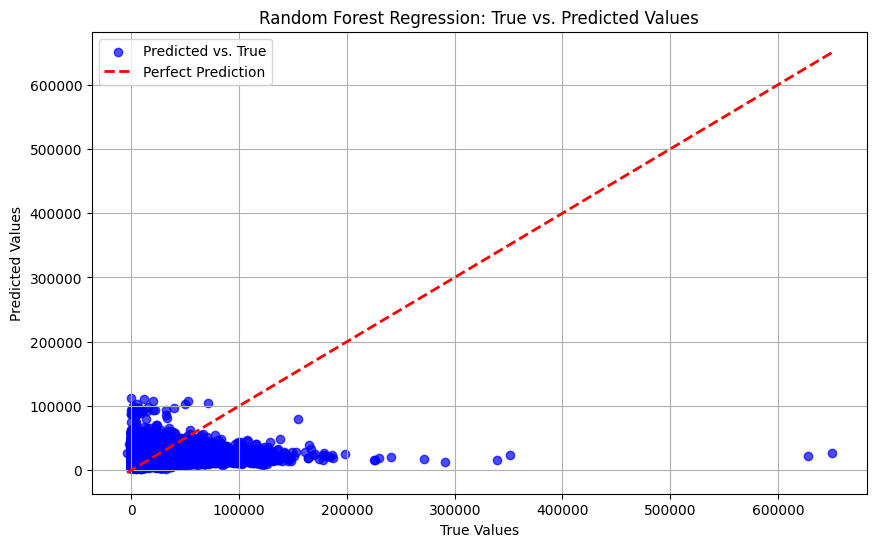

In [422]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue', label='Predicted vs. True', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Regression: True vs. Predicted Values')
plt.legend()
plt.grid()
plt.show()

### Forecasting  - ML techniques - need to develop

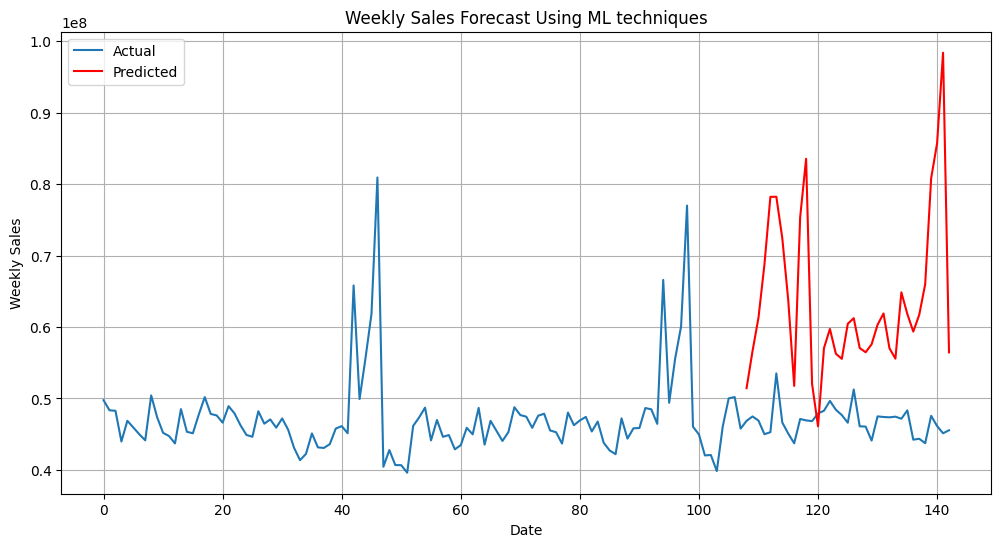

In [423]:
forescasting = df.copy()
forescasting = forescasting.sort_values(by=['Date'])
forescasting['predicted'] = None

x = len(y_test_pred)
forescasting.iloc[-x:, forescasting.columns.get_loc('predicted')] = y_test_pred

results = forescasting.groupby('Date')[['Weekly_Sales', 'predicted']].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(results.index, results['Weekly_Sales'], label='Actual')
plt.plot(results.index[-(results['predicted'] != 0).sum()+1:], results['predicted'][-(results['predicted'] != 0).sum()+1:], color='red', label='Predicted')
plt.legend()
plt.title('Weekly Sales Forecast Using ML techniques')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.show()

### Forecasting

In [424]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [425]:
forescasting = df.groupby('Date')['Weekly_Sales'].sum().reset_index()
forescasting['Date'] = pd.to_datetime(forescasting['Date'])
forescasting.set_index('Date', inplace=True)
forescasting.sort_index(inplace=True)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


Mean Squared Error: 6947383403602.243


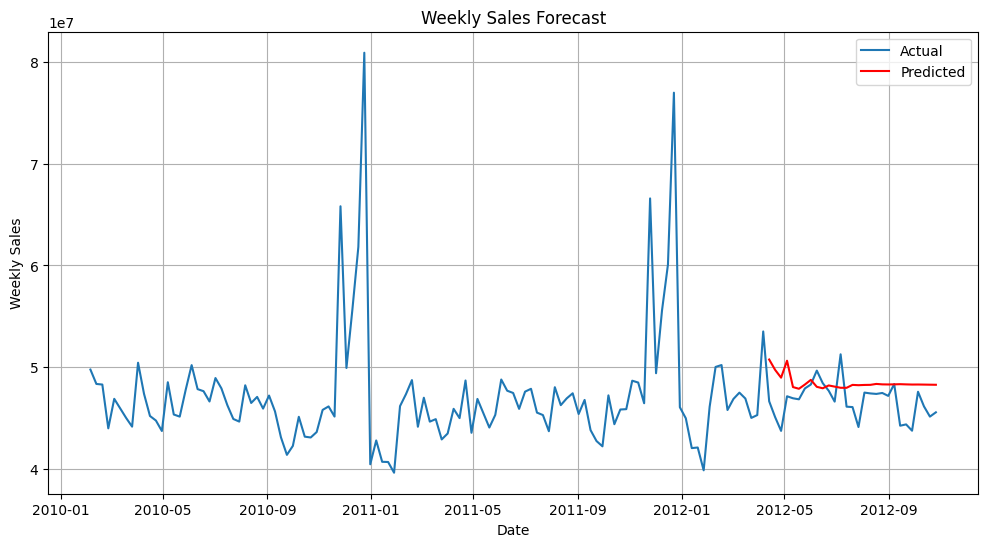

In [426]:
train_size = int(len(forescasting) * 0.8)
train_data = forescasting[:train_size]
test_data = forescasting[train_size:]

model = ARIMA(train_data['Weekly_Sales'], order=(10, 1, 1))
model_fit = model.fit()

predictions = model_fit.get_forecast(steps=len(test_data)).predicted_mean

mse = ((test_data['Weekly_Sales'] - predictions) ** 2).mean()
print(f"Mean Squared Error: {mse}")

plt.figure(figsize=(12, 6))
plt.plot(forescasting.index, forescasting['Weekly_Sales'], label='Actual')
plt.plot(test_data.index, predictions, color='red', label='Predicted')
plt.legend()
plt.title('Weekly Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.show()